In [1]:
import pandas as pd
import pyodbc
from SQL_Data import SQLData

import plotly.graph_objects as go
from plotly.subplots import make_subplots

conn = SQLData()

data = conn.fetch_table_to_dataframe("DT_Scraper")
#data = data[data['source'] == "MNI"]
data = data[['datetime', 'sentiment', 'score', 'effect', 'ID']]
data.dropna(inplace=True)

data['effect'] = data['effect'].replace({
    'Long-term':  'Long',
    'Short-term': 'Short'
})

data['sentiment'] = data['sentiment'].str.strip().str.title()

data['date'] = pd.to_datetime(data['datetime']).dt.date

data['day_of_week'] = data['datetime'].dt.dayofweek

weekend_data = data[data['day_of_week'].isin([5, 6])]

c:\Users\Z_LAME\Desktop\Crawler\Lang Chain\SQL_Data.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, self.conn)


In [2]:
has_weekend_data = len(weekend_data) > 0
print(f"DataFrame contains weekend data: {has_weekend_data}")
print(f"Number of Saturday entries: {len(data[data['day_of_week'] == 5])}")
print(f"Number of Sunday entries: {len(data[data['day_of_week'] == 6])}")

DataFrame contains weekend data: True
Number of Saturday entries: 26
Number of Sunday entries: 82


In [3]:
data_shifted = data.copy()

def shift_to_monday(date):
    
    day_of_week = date.dayofweek
    
    # If it's a weekend day, adjust to next Monday
    if day_of_week == 5:  # Saturday
        return date + pd.Timedelta(days=2)  
    elif day_of_week == 6:  # Sunday
        return date + pd.Timedelta(days=1)  
    else:
        return date  #

data_shifted['datetime'] = data_shifted['datetime'].apply(shift_to_monday)


data_shifted['date'] = data_shifted['datetime'].dt.date
data_shifted['day_of_week'] = data_shifted['datetime'].dt.dayofweek


weekend_count_after = len(data_shifted[data_shifted['day_of_week'].isin([5, 6])])
print(f"Records on weekends after shifting: {weekend_count_after}")
print(f"Records on Monday after shifting: {len(data_shifted[data_shifted['day_of_week'] == 0])}")

Records on weekends after shifting: 0
Records on Monday after shifting: 5917


In [4]:
df = data_shifted

In [5]:
df['ID'].nunique()

29946

In [6]:

# select only long term sentiments
longterm_data = df[df['effect'].isin(["Long"])]

# create a df with the counts of long term sentiment
long_sentiment_count_df = longterm_data.groupby(['date', 'sentiment']).size().reset_index(name='count')

long_term_bull_count = long_sentiment_count_df[long_sentiment_count_df['sentiment']== "Bullish"]

long_term_bear_count = long_sentiment_count_df[long_sentiment_count_df['sentiment']=="Bearish"]

neutral_count = long_sentiment_count_df[long_sentiment_count_df['sentiment'] == "Neutral"]

neutral_count.set_index("date", inplace= True)
long_term_bear_count.set_index("date", inplace= True)
long_term_bull_count.set_index("date", inplace= True)

In [9]:
Y1 = "C:/Users/Z_LAME/Desktop/New Saparate Folder/Price Data/latest_trades.csv"

df = pd.read_csv(Y1,
                 sep=';',                    # Semicolon as delimiter
                 decimal=',',                # Comma as decimal separator
                 parse_dates=['Timestamp'])
#df.drop(columns=['Unnamed: 0'], inplace=True)
#df['TradingTime'] = pd.to_datetime(df['TradingTime'])

#df['TradingTime'].max()

df.drop('Unnamed: 6', axis=1, inplace=True)

df.sort_values(by='Timestamp', inplace=True)

In [11]:
Y1 = df.copy()

In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=('OHLC', 'Sentiment Count', 'Volume'),
    row_width=[0.2, 0.5, 0.7]
)

# OHCL data
fig.add_trace(
    go.Candlestick(
        x=Y1.index,
        open=Y1['Open'],
        high=Y1['High'],
        low=Y1['Low'],
        close=Y1['Close'],
        name='OHLC'
    ),
    row=1, col=1
)


fig.add_trace(
    go.Bar(
        x=long_term_bull_count.index,
        y=long_term_bull_count['count'],
        name='Bull Counts',
        marker_color='rgba(0,128,0,0.8)'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Bar(
        x = long_term_bear_count.index,
        y = - long_term_bear_count['count'],
        name = 'Bear Counts',
        marker_color = 'rgba(255,0,0,0.8)'
    ),
    row= 2, col=1
)

#makes the graph not too great
'''fig.add_trace(

    go.Bar(
        x = neutral_count.index,
        y = neutral_count['count'],
        name = 'Neutral News',
        marker_color = 'rgba(133,20,0,0.8)'
        
    ),
    row= 2, col=1
)'''

fig.add_trace(
    go.Bar(
        x = Y1.index,
        y = Y1['Volume'],
        name = 'Volume',
        marker_color='rgba(138,43,226,0.6)'
    ),
    row= 3, col=1
)

# Update layout
fig.update_layout(
    title='OHLC / Sentiment',
    xaxis_rangeslider_visible=False,
    showlegend=True,
    barmode = 'overlay'
)

# Update y-axes labels
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Sentiment Count", row=2, col=1)

fig.show()

In [77]:
neutral_count.tail()

,sentiment,count
date,,
2025-07-16,Neutral,12
2025-07-18,Neutral,1
2025-07-28,Neutral,1
2025-08-12,Neutral,1
2025-08-13,Neutral,1


# So Far We Only Have The Counts

### Traders Do Not React To News The Same Way, For That Reason We Will Weight The Impact Of News

In [13]:
longterm_data_bullish_score = longterm_data[longterm_data['sentiment']== "Bullish"]

longterm_data_bearish_score = longterm_data[longterm_data['sentiment']== "Bearish"]

longterm_bullish_scores_by_date = longterm_data_bullish_score.groupby('date')['score'].apply(list).to_dict()
longterm_bearish_scores_by_date = longterm_data_bearish_score.groupby('date')['score'].apply(list).to_dict()

In [14]:
# Create a dictionary to store the weighted scores for each date
weighted_scores_by_date = {}

# Process each date's scores
for date, scores in list(longterm_bullish_scores_by_date.items()):
    total_score = 0
    
    # Count how many of each score (1, 2, 3) appear
    score_counts = {1: 0, 2: 0, 3: 0}
    
    # Count occurrences of each score
    for score in scores:
        if score in score_counts:
            score_counts[score] += 1
    
    # Calculate weighted values
    for score_value in [1, 2, 3]:
        count = score_counts[score_value]
        if count > 0:
            # First occurrence is full value
            total_score += score_value
            
            # Subsequent occurrences are halved each time
            remaining = count - 1
            if remaining > 0:
                # Sum of geometric series: a * (1 - r^n) / (1 - r) where a = score_value/2, r = 1/2
                additional = (score_value / 2) * (1 - (0.5 ** remaining)) / 0.5
                total_score += additional
    
    weighted_scores_by_date[date] = total_score

# Convert to DataFrame for easier analysis
bullish_weighted_scores_df = pd.DataFrame.from_dict(weighted_scores_by_date, orient='index', columns=['weighted_score'])
bullish_weighted_scores_df.index.name = 'date'

# Display the results
#print(bullish_weighted_scores_df.head())
bullish_scores = bullish_weighted_scores_df

In [15]:
# Create a dictionary to store the weighted scores for each date (for bearish scores)
weighted_scores_by_date = {}

# Process each date's scores
for date, scores in list(longterm_bearish_scores_by_date.items()):
    total_score = 0
    
    # Count how many of each score (-1, -2, -3) appear
    score_counts = {-1: 0, -2: 0, -3: 0}
    
    # Count occurrences of each score
    for score in scores:
        if score in score_counts:
            score_counts[score] += 1
    
    # Calculate weighted values
    for score_value in [-1, -2, -3]:
        count = score_counts[score_value]
        if count > 0:
            # First occurrence is full value
            total_score += score_value
            
            # Subsequent occurrences are halved each time (but keep negative direction)
            remaining = count - 1
            if remaining > 0:
                # For negative scores, we still want to reduce the impact but keep them negative
                abs_score = abs(score_value)
                additional = -(abs_score / 2) * (1 - (0.5 ** remaining)) / 0.5
                total_score += additional
    
    weighted_scores_by_date[date] = total_score

# Convert to DataFrame for easier analysis
bearish_scores_df = pd.DataFrame.from_dict(weighted_scores_by_date, orient='index', columns=['weighted_score'])
bearish_scores_df.index.name = 'date'

# Display the results
#print(bearish_scores_df.head())

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=('OHLC','Weighted Scores'),
    row_width=[0.2, 0.4]
)

# OHCL data
fig.add_trace(
    go.Candlestick(
        x=Y1.index,
        open=Y1['Open'],
        high=Y1['High'],
        low=Y1['Low'],
        close=Y1['Close'],
        name='OHLC'
    ),
    row=1, col=1
)


fig.add_trace(
    go.Bar(
        x=bullish_scores.index,
        y=bullish_scores['weighted_score'],
        name='Bull Scores',
        marker_color='rgba(0,128,0,0.8)'
    ),
    row=2, col=1
)

fig.add_trace(
    go.Bar(
        x = bearish_scores_df.index,
        y = bearish_scores_df['weighted_score'],
        name = 'Bear Scores',
        marker_color = 'rgba(255,0,0,0.8)'
    ),
    row= 2, col=1
)

# Update layout
fig.update_layout(
    title='OHLC / Sentiment',
    xaxis_rangeslider_visible=False,
    showlegend=True,
    barmode = 'overlay'
)

# Update y-axes labels
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Sentiment Count", row=2, col=1)

fig.show()

In [17]:
Y1['spread'] = Y1['Open'] - Y1['Close']
data = data.rename(columns={'date': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])

In [18]:
df2 = pd.merge(long_term_bear_count, Y1, left_index= True, right_index= True, how="left")

df2 = pd.merge(
    df2, 
    long_term_bull_count, 
    left_index=True, 
    right_index=True, 
    how='left',
    suffixes=('_Bearish', '_Bullish')
)

df2.dropna(inplace= True)


# if spread is positive it means the day was Bearish
# example Open = 3, Close = 2 , Spread = Open - Close , Ground Truth = Bearish
# example Open = 1, Close = 3 , Spread = Open - Close , Ground Truth = Bullish
import numpy as np
df2['ground_truth'] = np.where(df2['spread'] > 0, 'Bearish', 'Bullish')

In [19]:
df2.drop(columns=['sentiment_Bearish', 'sentiment_Bullish'], inplace= True)

In [20]:
df2.tail(1)

,count_Bearish,Timestamp,Open,High,Low,Close,Volume,spread,count_Bullish,ground_truth
date,,,,,,,,,,


In [21]:
# predicted sentiment 

df2['langchain'] = np.where(
    df2['count_Bearish'] > df2['count_Bullish'], 'Bearish',
    np.where(
        df2['count_Bullish'] > df2['count_Bearish'], 'Bullish', 'Neutral'
    )
)

In [22]:
df2.tail(1)

,count_Bearish,Timestamp,Open,High,Low,Close,Volume,spread,count_Bullish,ground_truth,langchain
date,,,,,,,,,,,


In [88]:
df2 = df2[abs(df2['spread'])>1.5]

In [89]:
len(df2)

83

In [138]:
df2.index

DatetimeIndex(['2024-07-24', '2024-08-01', '2024-08-07', '2024-08-08',
               '2024-08-12', '2024-08-15', '2024-08-20', '2024-08-27',
               '2024-09-02', '2024-09-03', '2024-09-04', '2024-09-10',
               '2024-09-11', '2024-09-16', '2024-09-17', '2024-09-19',
               '2024-09-25', '2024-09-30', '2024-10-02', '2024-10-07',
               '2024-10-08', '2024-10-10', '2024-10-14', '2024-10-16',
               '2024-10-22', '2024-10-23', '2024-10-31', '2024-11-07',
               '2024-11-11', '2024-11-14', '2024-11-18', '2024-11-19',
               '2024-11-20', '2024-11-21', '2024-11-22', '2024-11-28',
               '2024-12-03', '2024-12-05', '2024-12-09', '2024-12-10',
               '2024-12-12', '2024-12-13', '2024-12-17', '2024-12-18',
               '2024-12-19', '2024-12-23', '2025-01-02', '2025-01-08',
               '2025-01-17', '2025-01-22', '2025-01-29', '2025-01-31',
               '2025-02-13', '2025-02-17', '2025-02-19', '2025-02-25',
      

In [91]:
df2.tail()

,count_Bearish,Open,High,Low,Close,Settlement,Volume,spread,count_Bullish,ground_truth,langchain
date,,,,,,,,,,,
2025-05-29,5,89.80,90.61,86.70,86.75,87.03,380.0,3.05,2.0,Bearish,Bearish
2025-06-02,6,85.16,87.74,85.16,87.00,86.91,390.0,-1.84,7.0,Bullish,Bullish
2025-06-16,2,93.15,94.04,90.80,91.00,91.97,886.0,2.15,7.0,Bearish,Bullish
2025-06-24,5,90.10,90.10,87.95,87.99,88.29,1043.0,2.11,6.0,Bearish,Bullish
2025-06-26,8,87.51,87.51,85.65,85.80,86.01,691.0,1.71,6.0,Bearish,Bearish


In [92]:
corr_matrix = df2[['count_Bullish','spread']]
corr_matrix.corr()

,count_Bullish,spread
count_Bullish,1.000000,-0.076359
spread,-0.076359,1.000000


In [93]:
df2.head()

,count_Bearish,Open,High,Low,Close,Settlement,Volume,spread,count_Bullish,ground_truth,langchain
date,,,,,,,,,,,
2024-07-24,2,87.84,90.65,87.20,90.65,90.07,626.0,-2.81,2.0,Bullish,Neutral
2024-08-01,8,94.50,97.40,93.86,97.26,97.22,940.0,-2.76,4.0,Bullish,Bearish
2024-08-07,4,93.89,96.94,93.15,96.55,96.11,487.0,-2.66,7.0,Bullish,Bullish
2024-08-08,2,96.35,98.00,95.81,97.94,97.66,540.0,-1.59,3.0,Bullish,Bullish
2024-08-12,3,97.01,102.21,97.00,99.19,98.86,811.0,-2.18,4.0,Bullish,Bullish


In [94]:
agreement = (df2['ground_truth'] == df2['langchain'])
accuracy = agreement.mean()
print("prediction accuracy with neutral included is:", accuracy)

df2_no_neutral = df2[df2['langchain'] != 'Neutral']
agreement_no_neutral = (df2_no_neutral['ground_truth'] == df2_no_neutral['langchain'])
accuracy_no_neutral = agreement_no_neutral.mean()

print(f"Prediction accuracy excluding neutral predictions: {accuracy_no_neutral:.4f}")

prediction accuracy with neutral included is: 0.4578313253012048
Prediction accuracy excluding neutral predictions: 0.5429


# Now We Check The Agreement Level but with the weighted scores not with count

In [95]:
#df1 = pd.merge(long_term_bear_count, Y1, left_index=True, right_index=True, how='left')
#df1.dropna(inplace=True)
df3 = pd.merge(bearish_scores_df, bullish_scores, left_index=True, right_index=True, how="left", suffixes=('_Bearish', '_Bullish'))
df3.fillna(0, inplace=True)

In [96]:
df3['final_score'] = df3['weighted_score_Bearish'] + df3['weighted_score_Bullish']

In [97]:
df3.drop(columns=['weighted_score_Bearish', 'weighted_score_Bullish'], inplace = True)

In [98]:
df4 = pd.merge(df2, df3, left_index=True, right_index=True, how="left"
               )

In [99]:
df4['langchain_score'] = np.where(
    df4['final_score'] > 0.5, 'Bullish',
    np.where(
        df4['final_score'] < -0.5, 'Bearish',
        'Neutral'
    )
)

In [100]:
df = df4[df4['langchain_score'] != "Neutral"]
aggrement_score = df['ground_truth'] == df['langchain_score']
aggrement_score.mean()

0.42424242424242425

In [101]:
strong_sentiment_days = df3[abs(df3['final_score']) > 2]
#strong_sentiment_days

In [102]:
len(strong_sentiment_days)

72

In [103]:
sentiment_table = pd.merge(strong_sentiment_days, df2, left_index=True, right_index=True, how="left")

In [104]:
sentiment_table.dropna(inplace=True)

In [105]:
sentiment_table['lang_chain_score'] = np.where(
    sentiment_table['final_score'] > 0, "Bullish",
    np.where(
        sentiment_table['final_score'] < 0, "Bearish", "Neutral"
    )
)

In [106]:
agreement_score = sentiment_table['ground_truth'] == sentiment_table['lang_chain_score']

In [107]:
agreement_score.mean()

0.375

In [108]:
correlation = sentiment_table[['final_score', 'spread']].corr()
print(correlation)

             final_score    spread
final_score     1.000000 -0.016663
spread         -0.016663  1.000000


In [109]:
correlation_value = df4['final_score'].corr(df4['spread'])
print(f"Correlation between final_score and spread: {correlation_value:.4f}")

Correlation between final_score and spread: 0.1750


In [110]:
df1 = pd.merge(long_term_bear_count, Y1, left_index=True, right_index=True, how='left')

In [111]:
df1 = pd.merge(
    df1, 
    long_term_bull_count, 
    left_index=True, 
    right_index=True, 
    how='left',
    suffixes=('_Bearish', '_Bullish')
)

In [112]:
df1.isnull().sum()

sentiment_Bearish    0
count_Bearish        0
Open                 6
High                 6
Low                  6
Close                6
Settlement           4
Volume               6
spread               6
sentiment_Bullish    7
count_Bullish        7
dtype: int64

In [113]:
df1.dropna(inplace=True)

In [114]:
#df1.drop(columns=['sentiment_Bearish','sentiment_Bullish'], inplace= True)

In [115]:
df1.head(4)

,sentiment_Bearish,count_Bearish,Open,High,Low,Close,Settlement,Volume,spread,sentiment_Bullish,count_Bullish
date,,,,,,,,,,,
2024-07-24,Bearish,2,87.84,90.65,87.20,90.65,90.07,626.0,-2.81,Bullish,2.0
2024-07-25,Bearish,4,90.23,90.70,88.72,88.95,88.84,407.0,1.28,Bullish,3.0
2024-07-26,Bearish,3,89.99,91.00,89.24,90.60,90.70,495.0,-0.61,Bullish,4.0
2024-07-30,Bearish,1,92.51,93.20,90.97,92.95,92.68,428.0,-0.44,Bullish,2.0


In [116]:
df1['returns'] = df1['Settlement'].pct_change()

In [117]:
df1.dropna(inplace=True)

In [118]:
# Using numpy.where for conditional logic

# this is not super ideal because are only using count to determine the sentiment of the day

import numpy as np

df1['final_sentiment'] = np.where(
    df1['count_Bearish'] > df1['count_Bullish'], 'Bearish',
    np.where(df1['count_Bearish'] == df1['count_Bullish'], 'Neutral', 'Bullish')
)

In [119]:
bullish_returns = df1[df1['final_sentiment'] == 'Bullish']['returns']
bearish_returns = df1[df1['final_sentiment'] == 'Bearish']['returns']

In [120]:
from scipy import stats

# Then your existing code will work
t_stat, p_value = stats.ttest_ind(bullish_returns, bearish_returns, equal_var=False)

# Print the results
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 1.793306906928599
p-value: 0.07475612667495585


In [121]:
print(f"Bullish mean: {bullish_returns.mean():.6f}")
print(f"Bearish mean: {bearish_returns.mean():.6f}")
print(f"p-value: {p_value:.6f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")


Bullish mean: 0.002253
Bearish mean: -0.002386
p-value: 0.074756
Significant: No


count    140.000000
mean       0.002253
std        0.019098
min       -0.053202
25%       -0.007971
50%        0.001844
75%        0.013569
max        0.049259
Name: returns, dtype: float64
count    76.000000
mean     -0.002386
std       0.017624
min      -0.033379
25%      -0.015749
50%      -0.004722
75%       0.008582
max       0.048986
Name: returns, dtype: float64


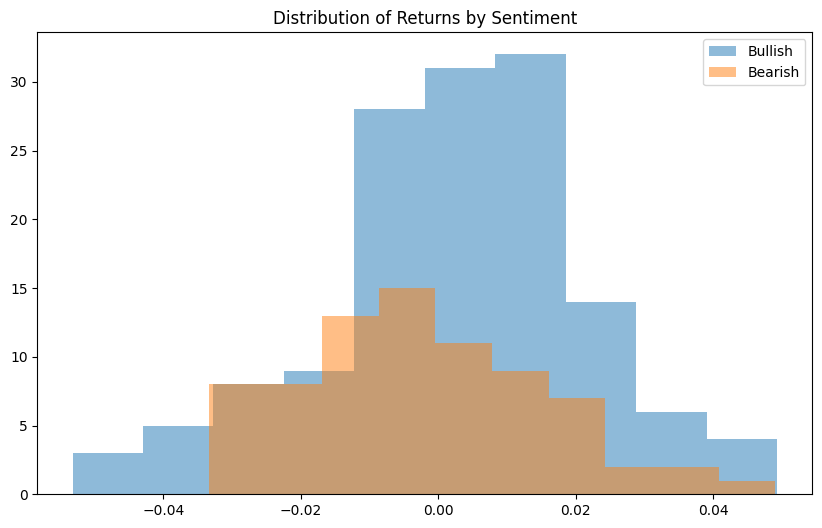

In [122]:
# Descriptive statistics
print(bullish_returns.describe())
print(bearish_returns.describe())

# Visualize distributions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(bullish_returns, alpha=0.5, label='Bullish')
plt.hist(bearish_returns, alpha=0.5, label='Bearish')
plt.legend()
plt.title('Distribution of Returns by Sentiment')
plt.show()

In [123]:
df1 = pd.merge(
    df1,
    bullish_scores,
    left_index=True,
    right_index=True,
    how='left',
    suffixes=('', '_bull_score')
)

In [124]:
df1 = pd.merge(
    df1,
    bearish_scores_df,
    left_index=True,
    right_index=True,
    how = "left",
    suffixes=('','_bear_score')
)

In [125]:
df1['weight_sentiment'] = np.where(
    abs(df1['weighted_score_bear_score']) > abs(df1['weighted_score']), 'Bearish',
    np.where(abs(df1['weighted_score_bear_score']) == abs(df1['weighted_score']), 'Neutral', 'Bullish')
)

In [126]:
bullish_returns = df1[df1['weight_sentiment'] == 'Bullish']['returns']
bearish_returns = df1[df1['weight_sentiment'] == 'Bearish']['returns']

In [127]:
t_stat, p_value = stats.ttest_ind(bullish_returns, bearish_returns, equal_var=False)

# Print the results
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: 0.27934281266466293
p-value: 0.7802735951772575


In [128]:
print(f"Bullish mean: {bullish_returns.mean():.6f}")
print(f"Bearish mean: {bearish_returns.mean():.6f}")
print(f"p-value: {p_value:.6f}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")

Bullish mean: 0.000470
Bearish mean: -0.000283
p-value: 0.780274
Significant: No


count    129.000000
mean       0.000470
std        0.017841
min       -0.045087
25%       -0.010047
50%        0.001599
75%        0.012621
max        0.042391
Name: returns, dtype: float64
count    106.000000
mean      -0.000283
std        0.022557
min       -0.096633
25%       -0.013059
50%       -0.001492
75%        0.012511
max        0.049259
Name: returns, dtype: float64


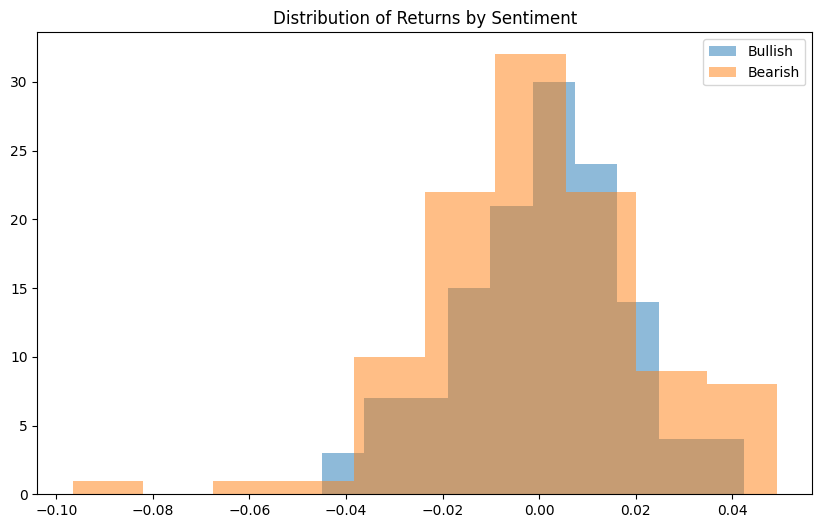

In [129]:
# Descriptive statistics
print(bullish_returns.describe())
print(bearish_returns.describe())

# Visualize distributions
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(bullish_returns, alpha=0.5, label='Bullish')
plt.hist(bearish_returns, alpha=0.5, label='Bearish')
plt.legend()
plt.title('Distribution of Returns by Sentiment')
plt.show()

In [130]:
df1['weight_sentiment']

date
2024-07-25    Bearish
2024-07-26    Bullish
2024-07-30    Bullish
2024-08-01    Bearish
2024-08-02    Neutral
               ...   
2025-07-11    Bearish
2025-07-14    Bullish
2025-07-15    Bearish
2025-07-16    Bullish
2025-07-21    Bullish
Name: weight_sentiment, Length: 244, dtype: object

In [131]:
df1['trading_day'] = np.where(df1['Close'] > df1['Open'], 'Bullish', 'Bearish')

In [132]:
df1_no_neutral = df1[df1['final_sentiment'] != 'Neutral']
agreement = (df1_no_neutral['final_sentiment'] == df1_no_neutral['trading_day'])
accuracy = agreement.mean()

In [133]:
print(f"Accuracy: {accuracy:.4f} ({agreement.sum()} out of {len(df1)} days)")

Accuracy: 0.5602 (121 out of 244 days)


In [134]:
print(f"Accuracy (excluding neutral days): {accuracy:.4f} ({agreement.sum()} out of {len(df1_no_neutral)} days)")

Accuracy (excluding neutral days): 0.5602 (121 out of 216 days)
